In [1]:
using OrdinaryDiffEq, ParameterizedFunctions
using Optim, LsqFit
using Plots, LaTeXStrings
using DelimitedFiles
using DataFrames
using Statistics
using Printf

In [2]:
ENV["COLUMNS"]=120
figdir = "figures/";

In [3]:
function print_fit_values(fit, par0, par_names, alpha=0.1)
    println(@sprintf "RSS = %.5f (convergence: %s)" sum(abs2, fit.resid) fit.converged)
    for i in 1:length(par0)
        name = par_names[i]
        val = fit.param[i]
        CIl = confidence_interval(fit, alpha)[i][1]
        CIr = confidence_interval(fit, alpha)[i][2]
        p0 = par0[i]
        println(@sprintf "  %s = %.3e (CI=(%.3e, %.3e), initial=%.3e)" name val CIl CIr p0)
    end
end

print_fit_values (generic function with 2 methods)

## ODE Model


The standard viral kinetic model with varying clearance rate reads
$$
\begin{aligned}
\frac{dT}{dt} & = -\beta T V, \\
\frac{dI_1}{dt} & = \beta T V - k I_1, \\
\frac{dI_2}{dt} & = k I_1 - \frac{\delta I_2}{K + I_2}, \\
\frac{dV}{dt} & = p I_2 -c V.
\end{aligned}
$$

*Smith, A. P., Moquin, D. J., Bernhauerova, V., & Smith, A. M. (2018). Influenza virus infection model with density dependence supports biphasic viral decay. Frontiers in Microbiology, 9(JUL), 1–10. https://doi.org/10.3389/fmicb.2018.01554*


In [71]:
ViralTarget = @ode_def begin
    dT = -β*T*V
    dI₁ = β*T*V - k*I₁
    dI₂ = k*I₁ - δ*I₂/(K + I₂)
    dV = p*I₂ - c*V
end β k δ K p c;
u0 = [1e+7, 75.0, 0.0, 1e0]
tspan = (0.0, tend)
pars = (β = 2.629e-04,
        k = 1.480e+00,
        δ = 1.593e+06,
        K = 7.899e+04,
        p = 2.090e+00,
        c = 1.505e+01)
function ViralTargetModel(t, p)
    prob = ODEProblem(ViralTarget, u0, tspan, p)
    sol = solve(prob, Rosenbrock23(), dtmax=1e-2)
    log10.(sol(t)[end, :])
end

ViralTargetModel (generic function with 1 method)

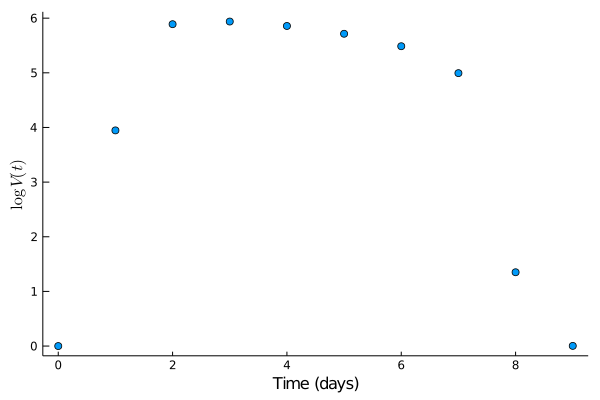

In [82]:
tend = 9.0
ttdata = Vector(range(0., tend, step=1.))
vvdata = ViralTargetModel(ttdata, pars)
plot(ttdata, vvdata, seriestype=:scatter,
    legend=:none, grid=:off,
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$"))

## Standard virus load function

Consider a virus load function with three main phases given by

$$V(t)=v_1(t)v_2(t)v_3(t),$$

where $v _1$ describes the initial growth phase between $a _1$ and $a _2$ , $v _2$ the intermediate slow decay
phase between $a _2$ and $b _1$, and $v _3$ the final decay phase between $b _1$ and $b _2$. These functions are given as sigmoid and exponential functions, respectively

$$
\begin{aligned}
v_1(t) & = 1 + \frac{V_{\max} - 1}{2} \left[ \tanh \left( \frac{6}{a_2 - a_1} \left( t - \frac{a_1 + a_2}{2} \right) \right) - \tanh  \left( -3\frac{a_2 + a_1}{a_2 - a_1} \right) \right] \\
v_2(t) & = (1 - H(t - a_2)) + H(t - a_2)e^{-\alpha(t - a_2)} \\
v_3(t) & = 1 - \frac{1 - V_{\min}}{2} \left[ \tanh \left( \frac{6}{b_2 - b_1} \left( t - \frac{b_1 + b_2}{2} \right) \right) - \tanh  \left( -3\frac{b_2 + b_1}{b_2 - b_1} \right) \right],
\end{aligned}
$$

where $H(t)$ denotes the Heaviside function.

In [83]:
heaviside(x::AbstractFloat) = ifelse(x < 0, zero(x), ifelse(x > 0, one(x), oftype(x,0.5)))
v₁(t, a₁, a₂, logVmax) = 1. + (10^logVmax - 1.0)*(tanh(6.0*(t - (a₁ + a₂)/2)/(a₂ - a₁)) - tanh(-3.0*(a₂ + a₁)/(a₂ - a₁)))/2
v₂(t, a₂, α) = 1. - heaviside(t - a₂) + heaviside(t - a₂)*exp(-α*(t - a₂))
v₃(t, b₁, b₂, logVmin) = 1. - (1.0 - 10^logVmin)*(tanh(6.0*(t - (b₁ + b₂)/2)/(b₂ - b₁)) - tanh(-3.0*(b₂ + b₁)/(b₂ - b₁)))/2
function VirusLoadFunction(t, p)
    a₁, a₂, b₁, b₂, α, logVmin, logVmax = p
    log10.(v₁.(t, a₁, a₂, logVmax).*v₂.(t, a₂, α).*v₃.(t, b₁, b₂, logVmin))
end
par_names = ["a₁", "a₂", "b₁", "b₂", "α", "logVmin", "logVmax"];

In [84]:
#       a₁,   a₂,   b₁,   b₂,   α,    logVmin, logVmax
par0 = [0.70, 2.88, 6.00, 7.60, 0.20, -6.0,   5.0]
lb   = [0.00, 1.00, 5.00, 7.00, 1e-8, -7.0,    4.0]
ub   = [1.00, 5.00, 7.00, 9.00, 10.0, -2.0,    7.0]
fit = curve_fit(VirusLoadFunction, ttdata, vvdata, par0, lower=lb, upper=ub)

LsqFit.LsqFitResult{Array{Float64,1},Array{Float64,1},Array{Float64,2},Array{Float64,1}}([0.7849007712939474, 2.807439385627103, 6.267119264035384, 7.654759561453418, 0.34511251355788763, -5.0727516437764555, 6.0028028114735905], [0.0, 2.100672138771742e-5, -0.00017379841813625063, 0.03553595291988376, -0.032929703237157604, -0.04027455446809114, 0.037843683632424074, -3.1893480504585625e-5, 9.938890077831886e-6, -6.3023386383948e-7], [0.0 0.0 … 0.0 0.0; -2.278692342515733 -0.2750032496417698 … 0.0 0.9998878405261559; … ; 8.418375469141317e-5 0.14985692428113961 … 0.0632761016163637 0.9999999999782052; 8.418374108395138e-5 0.14985692427281055 … 0.9974085208049304 0.9999999999788017], true, Float64[])

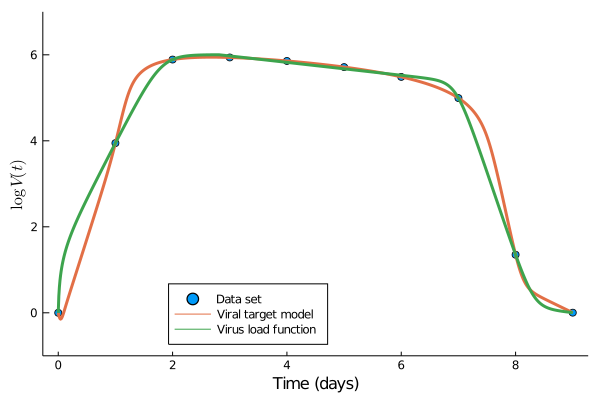

In [85]:
tt = Vector(range(0., tend, step=1e-2))
pt = plot(ttdata, vvdata, 
    label="Data set", seriestype=:scatter)
plot!(pt, tt, ViralTargetModel(tt, pars), lw=3,
    label="Viral target model")
plot!(pt, tt, VirusLoadFunction(tt, fit.param), lw=3,
    label="Virus load function", 
    grid=:off, legend=:bottom,
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$", (-1, 7)))
# savefig(figdir*"Smith2018VLFDataFit.png")
# savefig(figdir*"Smith2018VLFDataFit.pdf")
display(pt)

In [86]:
print_fit_values(fit, par0, par_names)

RSS = 0.00540 (convergence: true)
  a₁ = 7.849e-01 (CI=(7.218e-01, 8.480e-01), initial=7.000e-01)
  a₂ = 2.807e+00 (CI=(2.527e+00, 3.088e+00), initial=2.880e+00)
  b₁ = 6.267e+00 (CI=(6.162e+00, 6.372e+00), initial=6.000e+00)
  b₂ = 7.655e+00 (CI=(7.601e+00, 7.708e+00), initial=7.600e+00)
  α = 3.451e-01 (CI=(2.420e-01, 4.482e-01), initial=2.000e-01)
  logVmin = -5.073e+00 (CI=(-5.303e+00, -4.842e+00), initial=-6.000e+00)
  logVmax = 6.003e+00 (CI=(5.931e+00, 6.075e+00), initial=5.000e+00)


In [89]:
tend = 9.0
ttdata = Vector(range(0., tend, step=0.1))
vvdata = ViralTargetModel(ttdata, pars)
#       a₁,   a₂,   b₁,   b₂,   α,    logVmin, logVmax
par0 = [0.70, 2.88, 6.00, 7.60, 0.20, -6.0,   5.0]
lb   = [0.00, 1.00, 5.00, 7.00, 1e-8, -7.0,    4.0]
ub   = [1.00, 5.00, 7.00, 9.00, 10.0, -2.0,    7.0]
fit = curve_fit(VirusLoadFunction, ttdata, vvdata, par0, lower=lb, upper=ub)

LsqFit.LsqFitResult{Array{Float64,1},Array{Float64,1},Array{Float64,2},Array{Float64,1}}([0.8899261771081727, 2.052681781229772, 6.698994788446801, 7.779193536701351, 0.3536771844754151, -4.854896567975687, 6.0521439583417], [0.0, 0.15598204452633313, 0.016130574528053054, -0.026595535535781756, -0.025077455473802246, -0.0058402639533214895, 0.01886002129977493, 0.04223481865246548, 0.05664198516474617, 0.047345478989563095  …  0.15094174037753916, 0.05298548566128314, -0.05674626054758014, -0.10279746970785814, -0.09466872546348765, -0.06075582279396677, -0.01702363737285756, 0.030147361693920988, 0.07848516087393584, 0.1272134562331822], [0.0 0.0 … 0.0 0.0; -2.4966326771663643 0.9666047999516493 … 0.0 0.3413680526857767; … ; 2.0130036748423866e-6 0.15359917688046726 … 0.9993059496287751 1.0000000000050768; 2.0130013830593474e-6 0.15359917687935076 … 0.999771350062821 1.0000000000039408], true, Float64[])

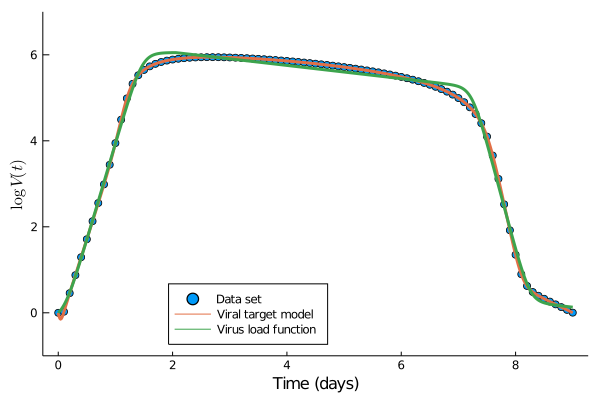

In [90]:
tt = Vector(range(0., tend, step=1e-2))
pt = plot(ttdata, vvdata, 
    label="Data set", seriestype=:scatter)
plot!(pt, tt, ViralTargetModel(tt, pars), lw=3,
    label="Viral target model")
plot!(pt, tt, VirusLoadFunction(tt, fit.param), lw=3,
    label="Virus load function", 
    grid=:off, legend=:bottom,
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$", (-1, 7)))
# savefig(figdir*"Smith2018VLFDataFit.png")
# savefig(figdir*"Smith2018VLFDataFit.pdf")
display(pt)